In [1]:
import os
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import preprocessing

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,
                             test_size=0.2)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [5]:
from sklearn.metrics import make_scorer, f1_score

pipe = Pipeline([
    ("scaler", preprocessing.StandardScaler()),
    ("svc", svm.SVC(class_weight=weight_dict))
])

param_grid = [
    # {
    #     "svc__kernel": ["linear"],
    #     "svc__C": np.logspace(0, 3.5, 25)
    # },
    {
        "svc__kernel": ["rbf"],
        "svc__C": np.logspace(0, 3.5, 25),
        "svc__gamma": ["scale", 0.01, 0.1]
    }
]

# # Set the SVM classifier
# svc = svm.SVC(class_weight=weight_dict)

# scaler = preprocessing.StandardScaler().fit(X_train)

# X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Use the f1 "weighted" score in a maker_scorer function.
wclf = GridSearchCV(pipe,
                    param_grid, 
                    # scoring=make_scorer(f1_score, average="weighted"),
                    scoring="f1_weighted",
                    verbose=3, 
                    cv=5)

# Start Training...
wclf.fit(X_train, y_train)


Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END svc__C=1.0, svc__gamma=scale, svc__kernel=rbf;, score=0.955 total time=   0.0s
[CV 2/5] END svc__C=1.0, svc__gamma=scale, svc__kernel=rbf;, score=0.950 total time=   0.0s
[CV 3/5] END svc__C=1.0, svc__gamma=scale, svc__kernel=rbf;, score=0.955 total time=   0.0s
[CV 4/5] END svc__C=1.0, svc__gamma=scale, svc__kernel=rbf;, score=0.963 total time=   0.0s
[CV 5/5] END svc__C=1.0, svc__gamma=scale, svc__kernel=rbf;, score=0.945 total time=   0.0s
[CV 1/5] END svc__C=1.0, svc__gamma=0.01, svc__kernel=rbf;, score=0.949 total time=   0.0s
[CV 2/5] END svc__C=1.0, svc__gamma=0.01, svc__kernel=rbf;, score=0.950 total time=   0.0s
[CV 3/5] END svc__C=1.0, svc__gamma=0.01, svc__kernel=rbf;, score=0.946 total time=   0.0s
[CV 4/5] END svc__C=1.0, svc__gamma=0.01, svc__kernel=rbf;, score=0.959 total time=   0.0s
[CV 5/5] END svc__C=1.0, svc__gamma=0.01, svc__kernel=rbf;, score=0.932 total time=   0.0s
[CV 1/5] END svc__C=1.0

,estimator,Pipeline(step..._('X'): 5}))])
,param_grid,"[{'svc__C': array([1.0000...16227766e+03]), 'svc__gamma': ['scale', 0.01, ...], 'svc__kernel': ['rbf']}]"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [12]:
final_clf = wclf.best_estimator_

# print(f"Kernel with the best result: {final_clf.kernel}")
# print(f"SVM information: {final_clf}")

In [13]:
# X_test_scaled = scaler.transform(X_test)

y_test_pred = final_clf.predict(X_test)

In [14]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["C", "S", "X", "Other"])

print(conf_mat)

[[ 78   0   1   0]
 [  0 105   0   5]
 [  2   1  43   2]
 [  0   0   0  31]]


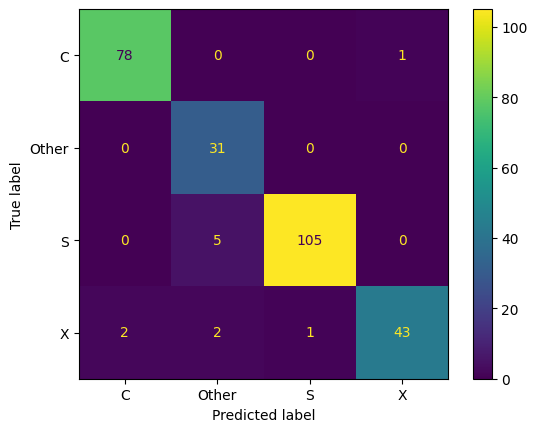

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    final_clf,
    X_test,
    y_test,
    values_format="d"
)

plt.show()


In [16]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.96


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           C       0.97      0.99      0.98        79
       Other       0.82      1.00      0.90        31
           S       0.99      0.95      0.97       110
           X       0.98      0.90      0.93        48

    accuracy                           0.96       268
   macro avg       0.94      0.96      0.95       268
weighted avg       0.96      0.96      0.96       268

